# Modeling
Data is separated on a candidate-basis to observe polls prior to and before a candidate suspends their campaign.

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import numpy as np
import pandas as pd
import os
import math

import stats

## Read File Written in 02-DataCleaning

In [2]:
candidates = pd.read_csv('candidates.csv', index_col='name')

## Read File Written in 03-Modeling

In [3]:
polls = pd.read_csv('bootPolls.csv')

Convert date from string to datetime.

In [4]:
polls.date = pd.Series(pd.DatetimeIndex(polls.date))
polls.index = polls.date
del polls['date']

candidates.date = pd.to_datetime(candidates.date)

stats.Equals100(polls)

## Data Modeling Functions Defintions

### Before Campaign Suspension

Function to get average polling for a single active candidate before a candidate drops out.

In [5]:
def getBeforeAverage(pollGroup, dropout, cand):
    """Returns average polling for a single candidate in the week prior to another candidate dropping out of the race.
    
    Parameters
    ----------
    pollGroup : DataFrame
        A snippet of the main DataFrame used sliced to only include polls take a week prior to and a week 
        after the dropout suspends their campaign.
    dropout : str
        The name of the candidate that dropped out.
    cand : str
        The name of the candidate whose average polling is being calculated.
    """
    
    tot = 0                             # used to as numerator in calculating the mean
    count = 0                           # regular iterator. Also used to as denominator in calculating the mean
    iterDate = pollGroup.index[count]   # used to check where date is relative to the date of suspension
    
    while candidates['date'][dropout] - iterDate >= datetime.timedelta(days=0):
        tot += pollGroup[cand][count]
        count += 1
        iterDate = pollGroup.index[count]

    return tot/count

Function to create list of average polling for all other candidates before a candidate drops out.

In [6]:
def BeforeAverages(pollGroup, dropout):
    """Returns a list of average polling for all active candidate in the week prior to another
       candidate dropping out of the race.
    
    Parameters
    ----------
    pollGroup : DataFrame
        A snippet of the main DataFrame used sliced to only include polls take a week prior to and a week 
        after the dropout suspends their campaign.
    dropout : str
        The name of the candidate that dropped out.
    """
    
    averages = []
    for c in pollGroup.columns:    # for each candidate
        averages.append(getBeforeAverage(pollGroup, dropout, c))
        
    return averages

### After Campaign Suspension

Function to retrieve difference in days since date of suspension/dropout.

In [7]:
def dateDiff(dropout, iterDate):
    """Returns difference in days between date iterator and the date a candidate dropped out of the race.
    
    Parameters
    ----------
    dropout : str
        The name of the candidate that dropped out.
    iterDate : str
        The name of the candidate whose average polling is being calculated.
    """
    return (iterDate - candidates['date'][dropout]).days

Function to get weighted average polling for a single active candidate after a candidate drops out. Weight is determined by days after campaign suspension; the further away from the date of suspension, the more weight the polling data holds.

In [8]:
def getAfterAverage(pollGroup, dropout, cand):
    """Returns average polling for a candidate in the week after another candidate drops out of the race.
    
    Parameters
    ----------
    pollGroup : DataFrame
        A snippet of the main DataFrame used sliced to only include polls take a week prior to and a week 
        after the dropout suspends their campaign.
    dropout : str
        The name of the candidate that dropped out.
    cand : str
        The name of the candidate whose average polling is being calculated.
    """
    
    tot = 0                             # used to as numerator in calculating the mean
    count = 0                           # regular iterator
    dateCount = 0                       # used to as denomiator in calculating the mean
    iterDate = pollGroup.index[count]   # used to check where date is relative to the date of suspension
    
    # Get the date iterator to the dropout date
    while candidates['date'][dropout] - iterDate >= datetime.timedelta(days=0):
        count += 1
        iterDate = pollGroup.index[count]
    
    # Iterates through poll grouping conducted in the week after a candidate dropped out of the race
    while count < len(pollGroup.index):
        iterDate = pollGroup.index[count]
        diff = dateDiff(dropout, iterDate)
        candCount = pollGroup[cand][count]
        
        if math.isnan(candCount) == False:    # only uses numbers
            tot += candCount * diff           # gives weight to polls conducted further away from the date of dropping
            dateCount += diff
        count += 1
        
    if dateCount == 0:    # can't divide by zero, so just return 0 if no polls conducted after date of dropping
        return float('nan')
    else:
        return tot/dateCount

Function to get weighted average polling for all other candidtates after a candidate drops out.

In [9]:
def AfterAverages(pollGroup, dropout):
    """Returns a list of average polling for all active candidate in the week after another
       candidate drops out of the race.
    
    Parameters
    ----------
    pollGroup : DataFrame
        A snippet of the main DataFrame used sliced to only include polls take a week prior to and a week 
        after the dropout suspends their campaign.
    dropout : str
        The name of the candidate that dropped out.
    """
    
    averages = []
    for c in pollGroup.columns:
        averages.append(getAfterAverage(pollGroup, dropout, c))
    return averages

## Data Modeling Functions Apllications

Create a list of dictionaries holding the name of each candidate that suspended their campaign and the DataFrames of polling data from a week before to a week after that candidate suspended their campaign.

In [10]:
pollList = []

pollIndex = [c for c in candidates.index if candidates.dropped[c] == True]
for p in pollIndex:
    pollList.append({'name': p, 'poll': stats.BiWeekPolling(polls, candidates, p)})

Create a DataFrame indexed by the candidates that dropped out of the race during the primaries. Each column holds other candidates' average polling numbers in the week prior to a candidate's campaign suspension.

Each cell contains the polling for a candidate in the column the week before the candidate in the row dropped out.

In [11]:
WeekBeforeDrop = []

for p in range(len(pollList)):
    WeekBeforeDrop.append(BeforeAverages(pollList[p]['poll'], pollList[p]['name']))
    
PollingBeforeDrop = pd.DataFrame(WeekBeforeDrop, columns=polls.columns, index=pollIndex)
PollingBeforeDrop.index.names = ['name']
stats.Equals100(PollingBeforeDrop)
PollingBeforeDrop

,Trump,Cruz,Kasich,Bush,Carson,Christie,Fiorina,Gilmore,Huckabee,Paul,Rubio,Santorum,Undecided
name,,,,,,,,,,,,,
Bush,38.140144,19.488856,6.013456,5.023567,8.067111,NaN,NaN,NaN,NaN,NaN,13.109856,NaN,10.157011
Carson,41.170333,17.902537,7.486778,NaN,7.980000,NaN,NaN,NaN,NaN,NaN,16.522907,NaN,8.937444
Christie,35.636463,20.414833,4.203944,4.474870,7.665000,2.553944,2.055000,0.028333,NaN,NaN,14.937148,NaN,8.030463
Fiorina,35.636463,20.414833,4.203944,4.474870,7.665000,2.553944,2.055000,0.028333,NaN,NaN,14.937148,NaN,8.030463
Gilmore,38.472074,19.490704,3.968685,5.519241,8.712963,NaN,NaN,0.026111,NaN,NaN,12.752370,NaN,11.057852
Huckabee,38.020667,17.741667,4.540667,4.465667,7.156111,1.961611,1.566778,0.160667,1.730333,2.684500,11.567389,0.770889,7.633056
Paul,38.997597,17.916708,4.708042,4.279569,6.926528,2.422278,1.637361,0.274167,NaN,2.636917,12.067542,0.658264,7.475028
Rubio,43.478426,22.191204,10.071944,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.281481,NaN,12.976944
Santorum,38.997597,17.916708,4.708042,4.279569,6.926528,2.422278,1.637361,0.274167,NaN,2.636917,12.067542,0.658264,7.475028


Create a DataFrame indexed by the candidates that dropped out of the race during the primaries. Each column holds other candidates' average polling numbers in the week after a candidate's campaign suspension.

Each cell contains the polling for a candidate in the column the week after the candidate in the row dropped out.

In [12]:
WeekAfterDrop = []

for p in range(len(pollList)):
    WeekAfterDrop.append(AfterAverages(pollList[p]['poll'], pollList[p]['name']))
    
PollingAfterDrop = pd.DataFrame(WeekAfterDrop, columns=polls.columns, index=pollIndex)
PollingAfterDrop.index.names = ['name']
stats.Equals100(PollingAfterDrop)
PollingAfterDrop

,Trump,Cruz,Kasich,Bush,Carson,Christie,Fiorina,Gilmore,Huckabee,Paul,Rubio,Santorum,Undecided
name,,,,,,,,,,,,,
Bush,37.121489,19.401219,8.366950,NaN,7.556389,NaN,NaN,NaN,NaN,NaN,15.414469,NaN,12.139483
Carson,44.160089,21.994800,10.422659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.807244,NaN,11.615207
Christie,37.599087,19.257773,7.270493,4.415913,7.944734,NaN,NaN,0.033333,NaN,NaN,13.455768,NaN,10.022898
Fiorina,37.599087,19.257773,7.270493,4.415913,7.944734,NaN,NaN,0.033333,NaN,NaN,13.455768,NaN,10.022898
Gilmore,37.339127,19.338353,7.391210,4.308426,8.010317,NaN,NaN,NaN,NaN,NaN,13.562917,NaN,10.049649
Huckabee,35.769601,19.234263,4.481146,4.043949,7.192677,2.599379,1.872727,0.086364,NaN,2.6785,15.081157,0.300833,6.659404
Paul,38.626753,19.554844,4.105089,5.665908,8.744583,2.590389,2.161944,0.027833,NaN,NaN,12.603136,NaN,5.919519
Rubio,42.008203,26.025790,14.387865,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.578142
Santorum,38.626753,19.554844,4.105089,5.665908,8.744583,2.590389,2.161944,0.027833,NaN,NaN,12.603136,NaN,5.919519


## Testing
Confirm DataFrame snippets are working as expected. Test on Jeb Bush.

Display date of drop.

In [13]:
candidates['date']['Bush']

Timestamp('2016-02-16 00:00:00')

Confirm data is saved properly after being pushed to a list of dictionaries.

In [14]:
BushPolls1 = polls[(polls.index > candidates['date']['Bush'] - datetime.timedelta(days=7)) \
     & (polls.index < candidates['date']['Bush'] + datetime.timedelta(days=9))]
BushPoll2 = pollList[1]['poll']
assert all(BushPolls1) == all(BushPoll2)

Display polling for candidates a week before to a week after Jeb Bush dropped.

In [15]:
BushPolls1

,Trump,Cruz,Kasich,Bush,Carson,Christie,Fiorina,Gilmore,Huckabee,Paul,Rubio,Santorum,Undecided
date,,,,,,,,,,,,,
2016-02-10,36.076778,21.743778,3.265500,5.937722,9.710000,2.624389,2.435556,0.023333,NaN,NaN,13.378778,NaN,4.804167
2016-02-11,42.229333,17.840944,4.795056,6.481444,8.870000,NaN,NaN,0.033333,NaN,NaN,10.468722,NaN,9.281167
2016-02-14,38.197778,18.908889,7.072222,3.708333,7.451667,NaN,NaN,NaN,NaN,NaN,13.016667,NaN,11.644444
2016-02-15,37.966778,19.462944,7.745222,4.602167,5.482778,NaN,NaN,NaN,NaN,NaN,15.216833,NaN,9.523278
2016-02-16,36.230056,19.487722,7.189278,4.388167,8.821111,NaN,NaN,NaN,NaN,NaN,13.468278,NaN,10.415389
2016-02-17,37.506333,19.315889,7.467944,NaN,9.101667,NaN,NaN,NaN,NaN,NaN,12.864778,NaN,13.743389
2016-02-21,36.843778,19.274833,7.610611,NaN,7.456111,NaN,NaN,NaN,NaN,NaN,14.727611,NaN,14.087056
2016-02-22,36.851722,17.898833,10.037889,NaN,7.633889,NaN,NaN,NaN,NaN,NaN,17.986056,NaN,9.591611
2016-02-24,37.449278,20.617667,7.698833,NaN,7.367778,NaN,NaN,NaN,NaN,NaN,14.233778,NaN,12.632667


Confirm polling data sums up to 100 for each poll

In [16]:
sum(BushPolls1.loc['2016-02-22'].dropna())

100.0

In [17]:
assert sum(BushPolls1.loc['2016-02-10'].dropna()) == 100
assert sum(BushPolls1.loc['2016-02-22'].dropna()) == 100

Confirm polling before drop is accurate.

In [18]:
BushBeforeAvgs1 = BeforeAverages(BushPolls1, 'Bush')
BushBeforeAvgs2 = PollingBeforeDrop.loc['Bush']
assert all(BushBeforeAvgs1) == all(list(BushBeforeAvgs2))
assert sum(BushBeforeAvgs2.dropna()) == 100

Display candidates' average polling data in the week before Jeb Bush suspended his campaign.

In [19]:
print(BushBeforeAvgs1)

[38.140144444444445, 19.488855555555553, 6.0134555555555558, 5.0235666666666665, 8.067111111111112, nan, nan, nan, nan, nan, 13.109855555555551, nan, 9.1336888888888978]


Confrim polling after drop is accurate.

In [20]:
BushAfterAvgs1 = AfterAverages(BushPolls1, 'Bush')
BushAfterAvgs2 = PollingAfterDrop.loc['Bush']
assert all(BushAfterAvgs1) == all(list(BushAfterAvgs2))

Display candidates' average polling data in the week after Jeb Bush suspended his campaign.

In [21]:
print(BushAfterAvgs1)

[37.121488888888884, 19.401219444444443, 8.3669499999999992, nan, 7.5563888888888897, nan, nan, nan, nan, nan, 15.414469444444444, nan, 12.139483333333347]


Polling data sums up to 100.

In [22]:
for p in range(len(PollingBeforeDrop.index)):
    assert sum(PollingBeforeDrop.iloc[p].dropna()) == 100
    
for p in range(len(PollingAfterDrop.index)):
    assert sum(PollingAfterDrop.iloc[p].dropna()) == 100

Graph Jeb Bush's data.

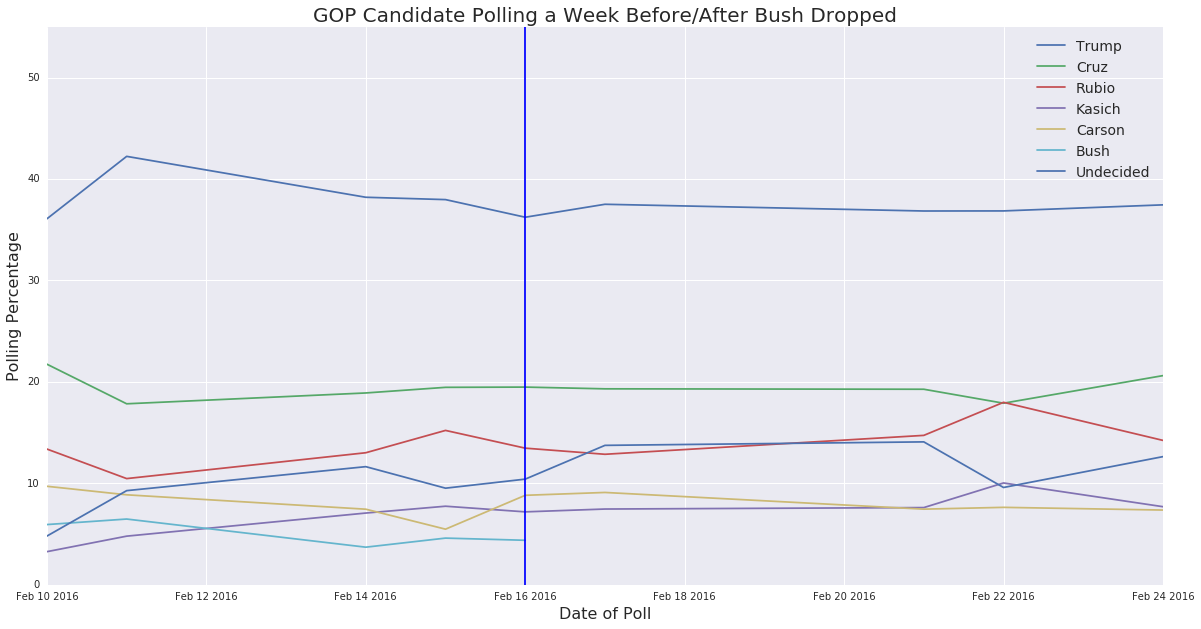

In [23]:
plt.figure(figsize=(20,10))

plt.plot(BushPolls1.Trump)
plt.plot(BushPolls1.Cruz)
plt.plot(BushPolls1.Rubio)
plt.plot(BushPolls1.Kasich)
plt.plot(BushPolls1.Carson)
plt.plot(BushPolls1.Bush)
plt.plot(BushPolls1.Undecided)

plt.axvline(candidates['date']['Bush'])

plt.title("GOP Candidate Polling a Week Before/After Bush Dropped", size=20)
plt.xlabel("Date of Poll", size=16)
plt.ylabel("Polling Percentage", size=16)

# y limits are a little greater than needed to display the legend without blocking out data
plt.ylim(0, 55)
plt.legend(fontsize=14)

## Write to File
Write the DataFrames PollingBeforeDrop and PollingAfterDrop to two separte files to be analyzed in 05-Analysis.ipynb

In [24]:
PollingBeforeDrop.to_csv('PollingBeforeDrop.csv')
PollingAfterDrop.to_csv('PollingAfterDrop.csv')